In [61]:
import requests
import pandas as pd
import geopandas as gpd
from scipy import stats

import matplotlib.pyplot as plt
import contextily as cx

from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(50)

 - CurieuzenAir Report: https://curieuzenair.brussels/wp-content/uploads/2022/03/CurieuzenAir_AirQualityInBrussels-Report-Final-Version.pdf
 - CureuzenAir: https://www.lesoir.be/cartecurieuzenair#11/50.84/4.36
 - Quartier: https://monitoringdesquartiers.brussels/
 - Irceline: https://geo.irceline.be/sos/

In [2]:
link = "https://markup.standaard.be/extra/assets/extra/dslive/anti/cnair/curieuzenair-2022-03-15.json"
rep = requests.get(link, headers={'User-Agent': 'Mozilla/5.0'})
with open("datasets/curieuzenair.json", "wb") as handler:
    handler.write(rep.content)

In [3]:
df = pd.json_normalize(rep.json()["features"])

In [4]:
df.columns = [column.split(".")[-1] for column in df.columns]

In [5]:
df.sample(5)

,type,cnId,muni,zip,lng,lat,green,housing,traffic,road,no2cat,no2,floor,type,coordinates
1504,Feature,130265,1000,1000,4.347418,50.842569,green-none,housing-closed,traffic-none,road-one-way,25,25.49,1,Point,"[4.347418354, 50.84256926]"
456,Feature,147692,1200,1200,4.422796,50.846294,green-small,housing-closed,traffic-frequent,road-one-way,15,18.20,1,Point,"[4.4227962, 50.84629356]"
2351,Feature,137276,1080,1080,4.324684,50.849114,green-none,housing-closed,traffic-frequent,road-two-way,35,35.10,2,Point,"[4.324684451, 50.84911377]"
1749,Feature,146045,1190,1190,4.334889,50.824961,green-big,housing-closed,traffic-frequent,road-two-way-split,25,27.31,1,Point,"[4.334888741, 50.82496086]"
322,Feature,130298,1170,1170,4.399193,50.803624,green-small,housing-free,traffic-none,road-two-way,15,16.19,0,Point,"[4.399192912, 50.8036236]"


In [6]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lng, df.lat), crs=4326
)
gdf["coords"] = gdf["geometry"]
gdf = gdf.to_crs(31370)

In [8]:
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

In [9]:
gdf.to_pickle("datasets/curieuzenair.pickle")

In [ ]:
neighboors = gpd.read_file("datasets/neighboors.json", crs=4326)
neighboors["coords"] = neighboors["geometry"]
neighboors = neighboors.to_crs(31370)

In [60]:
neighboors.to_pickle("datasets/neighboors.pickle")

In [86]:
t0 = pd.Timestamp("2021-09-25T00:00:00+01:00")
t1 = pd.Timestamp("2021-10-23T00:00:00+01:00")

In [43]:
client = Irceline()
meta = client.select(sitekey="41", measurekey="NO2")

2022-03-20 06:48:31,842	odapi             	generic     	load        	DEBUG 	Load Settings /home/jlandercy/.local/lib/python3.6/site-packages/odapi-0.1.3-py3.6.egg/odapi/connectors/opendata/resources/irceline.json
2022-03-20 06:48:31,853	odapi             	api         	select      	DEBUG 	Selection Keys: {'sitekey': '41', 'measurekey': 'NO2'}
2022-03-20 06:48:34,800	odapi             	irceline    	fetch       	DEBUG 	GET [200]: https://geo.irceline.be/sos/api/v1/timeseries/?expanded=true
2022-03-20 06:48:35,126	odapi             	irceline    	get_metadata	DEBUG 	FRAME: (634, 38) metadata fetched
2022-03-20 06:48:35,141	odapi             	api         	select      	DEBUG 	Selected 12 row(s): {'100036', '6551', '6622', '6528', '100032', '6516', '6574', '6615', '10614', '6508', '6504', '6561'}


In [46]:
gmeta = gpd.GeoDataFrame(
    meta, geometry=gpd.points_from_xy(meta.lat, meta.lon), crs=4326
)
gmeta["coords"] = gmeta["geometry"]
gmeta = gmeta.to_crs(31370)

In [49]:
gmeta.to_pickle("datasets/sites.pickle")

In [80]:
records = client.get_records(meta, start="2018-01-01T00:00:00+01:00", stop="2022-01-01T00:00:00+01:00")

In [83]:
series = records.merge(meta[["serieid", "seriekey"]]).pivot_table(index="start", columns="seriekey", values="value")

In [85]:
series.to_pickle("datasets/series.pickle")

In [90]:
sample = series.loc[t0:t1, :]

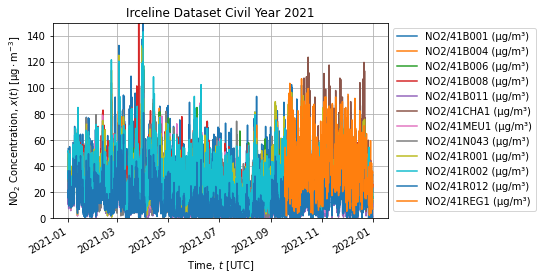

In [105]:
axe = series.loc["2021",:].plot()
axe.set_title("Irceline Dataset: Civil Year 2021")
axe.set_xlabel(r"Time, $t$ [UTC]")
axe.set_ylabel(r"$\mathrm{NO}_2$ Concentration, $x(t)$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_ylim([0, 150])
axe.grid()

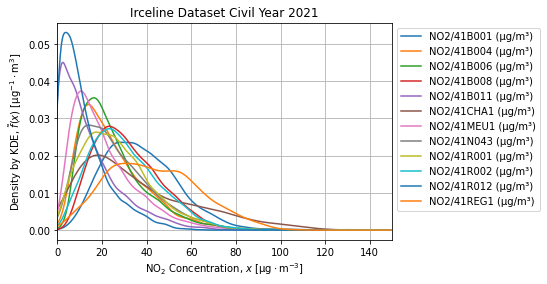

In [106]:
axe = series.loc["2021",:].plot(kind="kde")
axe.set_title("Irceline Dataset: Civil Year 2021")
axe.set_xlabel(r"$\mathrm{NO}_2$ Concentration, $x$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.set_ylabel(r"Density by KDE, $\tilde{f}(x)$ $[\mathrm{\mu g^{-1} \cdot m^{3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_xlim([0, 150])
axe.grid()

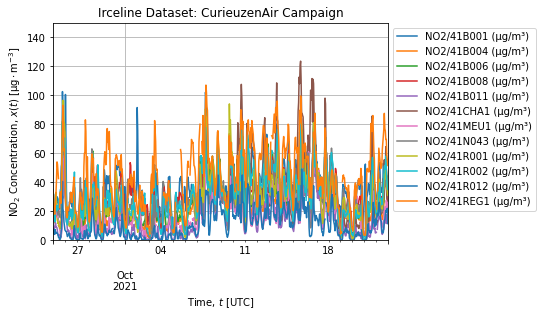

In [107]:
axe = sample.plot()
axe.set_title("Irceline Dataset: CurieuzenAir Campaign")
axe.set_xlabel(r"Time, $t$ [UTC]")
axe.set_ylabel(r"$\mathrm{NO}_2$ Concentration, $x(t)$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_ylim([0, 150])
axe.grid()

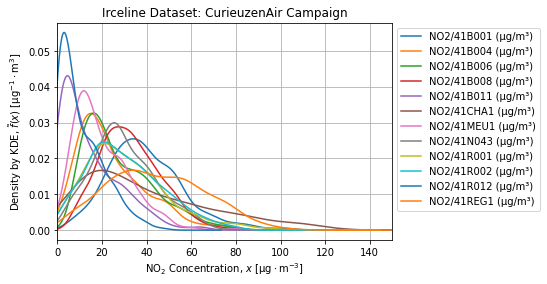

In [109]:
axe = sample.plot(kind="kde")
axe.set_title("Irceline Dataset: CurieuzenAir Campaign")
axe.set_xlabel(r"$\mathrm{NO}_2$ Concentration, $x$ $[\mathrm{\mu g \cdot m^{-3}}]$")
axe.set_ylabel(r"Density by KDE, $\tilde{f}(x)$ $[\mathrm{\mu g^{-1} \cdot m^{3}}]$")
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_xlim([0, 150])
axe.grid()

In [124]:
period = (t1 - t0)/pd.Timedelta("1h")

In [125]:
reference = sample.agg(["count", "mean", "median",  "std"])
reference

,NO2/41B001 (µg/m³),NO2/41B004 (µg/m³),NO2/41B006 (µg/m³),NO2/41B008 (µg/m³),NO2/41B011 (µg/m³),NO2/41CHA1 (µg/m³),NO2/41MEU1 (µg/m³),NO2/41N043 (µg/m³),NO2/41R001 (µg/m³),NO2/41R002 (µg/m³),NO2/41R012 (µg/m³),NO2/41REG1 (µg/m³)
count,660.000000,659.000000,640.000000,640.000000,663.000000,307.000000,618.000000,660.000000,585.000000,660.000000,664.000000,637.000000
mean,39.332576,24.286798,27.606250,32.574219,14.442685,39.006515,19.979773,29.790909,30.551282,30.315909,10.728916,44.274725
median,37.500000,20.500000,23.000000,31.250000,10.500000,32.500000,17.000000,27.500000,27.500000,28.000000,7.500000,42.500000
std,16.689808,15.499720,15.363655,13.474936,13.198738,28.073869,12.585783,14.322995,18.088820,16.648531,9.862264,21.380994


In [127]:
reference.loc["expected",:] = period
reference.loc["performance",:] = reference.loc["count",:]/period

In [129]:
reference

,NO2/41B001 (µg/m³),NO2/41B004 (µg/m³),NO2/41B006 (µg/m³),NO2/41B008 (µg/m³),NO2/41B011 (µg/m³),NO2/41CHA1 (µg/m³),NO2/41MEU1 (µg/m³),NO2/41N043 (µg/m³),NO2/41R001 (µg/m³),NO2/41R002 (µg/m³),NO2/41R012 (µg/m³),NO2/41REG1 (µg/m³)
count,660.000000,659.000000,640.000000,640.000000,663.000000,307.000000,618.000000,660.000000,585.000000,660.000000,664.000000,637.000000
mean,39.332576,24.286798,27.606250,32.574219,14.442685,39.006515,19.979773,29.790909,30.551282,30.315909,10.728916,44.274725
median,37.500000,20.500000,23.000000,31.250000,10.500000,32.500000,17.000000,27.500000,27.500000,28.000000,7.500000,42.500000
std,16.689808,15.499720,15.363655,13.474936,13.198738,28.073869,12.585783,14.322995,18.088820,16.648531,9.862264,21.380994
expected,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
performance,0.982143,0.980655,0.952381,0.952381,0.986607,0.456845,0.919643,0.982143,0.870536,0.982143,0.988095,0.947917


In [137]:
gmeta = gmeta.merge(reference.T.reset_index().rename(columns={"index": "seriekey"}))
gmeta.to_pickle("datasets/sites.pickle")

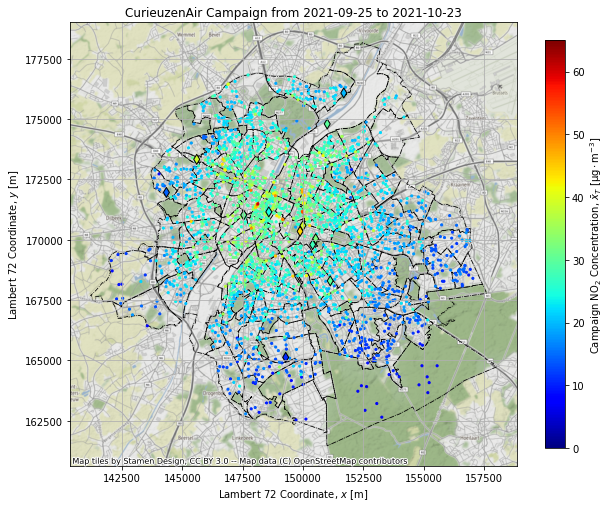

In [144]:
fig, axe = plt.subplots(figsize=(10,10))
neighboors.plot(aspect=1, linestyle="-.", color="none", edgecolor="black", linewidth=0.75, ax=axe)
cmap = axe.scatter(gdf.x, gdf.y, s=np.sqrt(20), c=gdf.no2, alpha=1.0, vmin=0., vmax=65., cmap="jet")
#gmeta.plot(marker='d', color="black", ax=axe)
axe.scatter(gmeta.geometry.x, gmeta.geometry.y, marker="d", edgecolor="black", s=50, c=gmeta["mean"], alpha=1.0, vmin=0., vmax=65., cmap="jet")
cb = fig.colorbar(cmap, shrink=0.75)
cb.set_label(r"Campaign $\mathrm{NO}_2$ Concentration, $\bar{x}_T$ $[\mathrm{\mu g \cdot m^{-3}}]$")
cx.add_basemap(axe, crs=31370)
axe.set_title("CurieuzenAir Campaign from {:%Y-%m-%d} to {:%Y-%m-%d}".format(t0, t1))
axe.set_xlabel("Lambert 72 Coordinate, $x$ [m]")
axe.set_ylabel("Lambert 72 Coordinate, $y$ [m]")
axe.grid()
fig.savefig("figures/points.png", dpi=150)